In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import tqdm
import torch
import torch.nn as nn
import numpy as np
import yaml
import matplotlib.pyplot as plt

from pathlib import Path
from easydict import EasyDict

In [3]:
# construct the dataset
from pcdet.datasets import KittiDatasetImVote

cfg_file = "/home/yzy/PycharmProjects/OpenPCDet/tools/cfgs/dataset_configs/kitti_dataset_imvote.yaml"
dataset_cfg = EasyDict(yaml.load(open(cfg_file)))
ROOT_DIR = (Path(os.path.abspath('')).resolve().parent / '../').resolve()
dataset = KittiDatasetImVote(dataset_cfg=dataset_cfg,
                             class_names=['Car', 'Pedestrian', 'Cyclist'],
                             root_path=ROOT_DIR / 'data' / 'kitti',
                             training=False)



/home/yzy/anaconda3/envs/openpcdet/lib/python3.7/site-packages/ipykernel_launcher.py:5: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  """


In [4]:
# get a sample
d_sample = dataset[0]
for k, v in d_sample.items():
    if isinstance(v, np.ndarray):
        print(k, v.shape)

points (16384, 4)
gt_boxes (2, 8)
road_plane (4,)
cls_score_feats (101, 3)
full_img_votes_1d (6054750,)
full_img_1d (1397250,)
voxels (15463, 5, 4)
voxel_coords (15463, 3)
voxel_num_points (15463,)


In [8]:
# build dataloader
from pcdet.datasets import build_dataloader

train_set, train_loader, train_sampler = build_dataloader(dataset_cfg=dataset_cfg,
                            class_names=['Car', 'Pedestrian', 'Cyclist'],
                            batch_size=5,
                            dist=False)
d_batch_sample = next(iter(train_loader))

In [9]:
for k, v in d_batch_sample.items():
    if isinstance(v, np.ndarray):
        print(k, v.shape)

points (81920, 5)
frame_id (5,)
calib (5,)
gt_boxes (5, 12, 8)
road_plane (5, 4)
cls_score_feats (5, 101, 3)
full_img_votes_1d (5, 6054750)
full_img_1d (5, 1397250)
full_img_width (5,)
full_img_height (5,)
use_lead_xyz (5,)
voxels (74778, 5, 4)
voxel_coords (74778, 4)
voxel_num_points (74778,)


In [10]:
d_batch_sample['gt_boxes']

array([[[ 9.7726431e+00,  8.9813194e+00, -1.1883225e+00,  3.3399999e+00,
          1.6200000e+00,  1.6600000e+00, -4.6507964e+00,  1.0000000e+00],
        [ 1.3051502e+01,  8.6306896e+00, -1.1827505e+00,  3.9400001e+00,
          1.5900000e+00,  1.4100000e+00, -4.6507964e+00,  1.0000000e+00],
        [ 1.5480589e+01,  8.3901606e+00, -9.3989778e-01,  3.5100000e+00,
          1.7700000e+00,  1.6900001e+00,  1.5592037e+00,  1.0000000e+00],
        [ 1.8361214e+01,  8.1812706e+00, -1.0220087e+00,  3.8599999e+00,
          1.6600000e+00,  1.6100000e+00, -4.7007966e+00,  1.0000000e+00],
        [ 2.3040920e+01,  8.3418436e+00, -9.8140639e-01,  3.9000001e+00,
          1.7100000e+00,  1.5900000e+00, -4.1607962e+00,  1.0000000e+00],
        [ 3.0851486e+01,  8.5638580e+00, -1.0774467e+00,  2.4300001e+00,
          1.5700001e+00,  1.4299999e+00, -4.2607965e+00,  1.0000000e+00],
        [ 3.3711975e+01,  8.0447721e+00, -1.0780433e+00,  3.7700000e+00,
          1.7400000e+00,  1.4800000e+00, -4.3

In [7]:
from pcdet.models import load_data_to_gpu

d_batch_sample['point_coords'] = d_batch_sample['points'][:, :4]
d_batch_sample['point_features'] = d_batch_sample['points'][:, 4:]
load_data_to_gpu(d_batch_sample)

In [8]:
# construct image module
from pcdet.models.backbones_3d.pfe import ImageFeatureModule

im_feature_module = ImageFeatureModule(None)

In [9]:
batch_dict = im_feature_module(d_batch_sample)

In [10]:
xyz_cat, img_feat_cat = batch_dict['seed_coords'], batch_dict['img_features']
print("xyz_cat: ", xyz_cat.shape)
print("img_feat_cat:", img_feat_cat.shape)

xyz_cat:  torch.Size([1024, 3])
img_feat_cat: torch.Size([1024, 256])


In [206]:
print("image shape: ", d_batch_sample['full_img_width'], d_batch_sample['full_img_height'])

image shape:  tensor([1242.], device='cuda:0') tensor([375.], device='cuda:0')


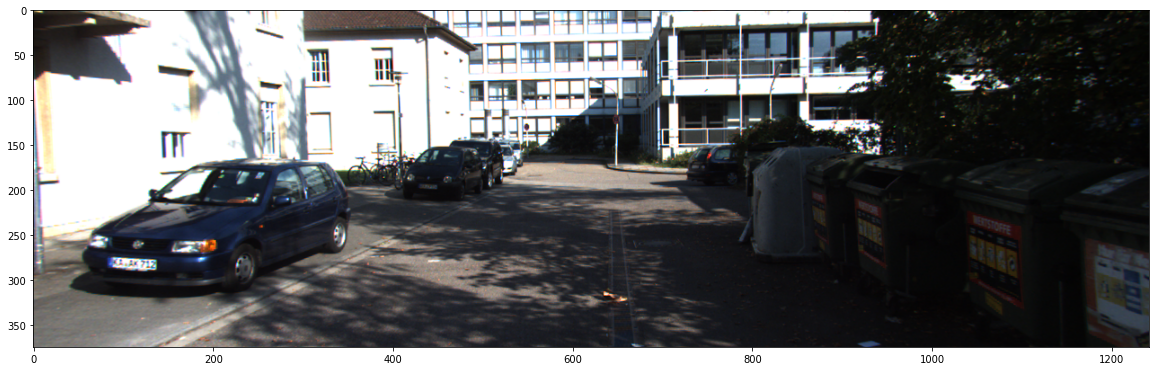

In [207]:
# reconstruct image
w, h = int(d_batch_sample['full_img_width']), int(d_batch_sample['full_img_height'])
full_image = d_batch_sample['full_img_1d'][:, :(w*h*3)].view(h, w, 3) * 255 + 128
full_image = full_image.long().cpu().numpy()
plt.figure(figsize=(20, 10))
plt.imshow(full_image)

In [208]:
# reconstruct vote
d_batch_sample['full_img_votes_1d'].shape
full_img_votes = d_batch_sample['full_img_votes_1d'][:, :(w*h*13)]
full_img_votes = full_img_votes.view(-1, 13)
full_img_votes.shape

torch.Size([465750, 13])

In [209]:
# draw vote
x, y = np.meshgrid(np.arange(w), np.arange(h))
grid = np.stack([x, y], axis=-1)
grid.shape

(375, 1242, 2)

In [210]:
start = grid.reshape((-1,2))
end = full_img_votes.view(-1, 13)[:, 1:3].cpu().numpy()

In [211]:
index = (end[:, 0]!=0)
start_obj = start[index, :]
end_obj = end[index, :] + start_obj

In [212]:
import cv2

full_image_vote = full_image.copy()
for l in tqdm.trange(0, len(start_obj), 100):
    full_image_vote = cv2.arrowedLine(cv2.UMat(full_image_vote),
                                      (int(start_obj[l, 0]), int(start_obj[l, 1])),
                                      (int(end_obj[l, 0]), int(end_obj[l, 1])),
                                      color = (0, 255, 0), thickness=2)

100%|██████████| 643/643 [00:03<00:00, 186.97it/s]


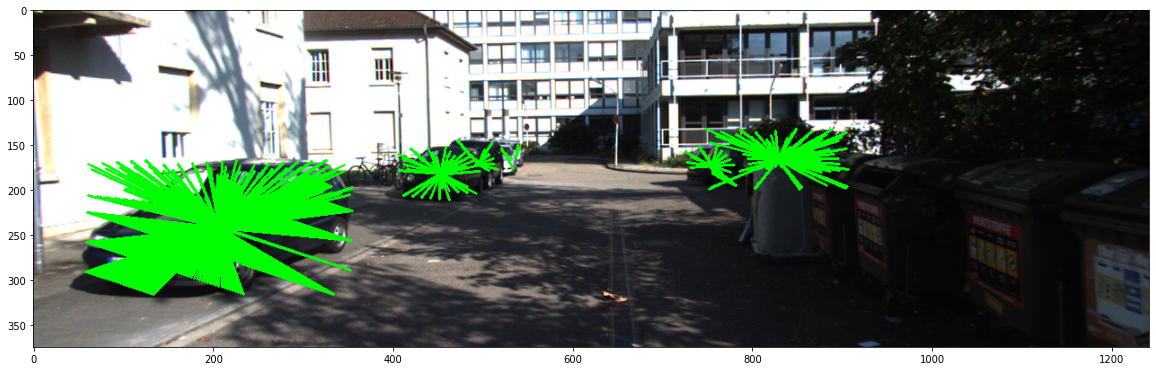

In [213]:
plt.figure(figsize=(20, 10))
plt.imshow(cv2.UMat.get(full_image_vote))

In [111]:
start_obj


array([], shape=(0, 2), dtype=int64)